# Setup 



In [ ]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

In [ ]:
!pip install vizdoom
!pip install ray 
!pip install ray['rllib']
!pip install Ipython --upgrade


In [1]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [3]:
from ray.tune.registry import register_env
import gym
import ray
import ray.rllib.agents.ppo as ppo
import shutil
import torch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Create and restore agent from checkpoint



In [5]:

ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")


Shutdown ray


2022-09-21 20:42:58,611	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


In [7]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = True #for ICM and RE3 might need to be left true to use the exploration module 
config['in_evaluation'] = True


#config["horizon"] = 50
#agent = ppo.PPOTrainer(config, env=select_env)
#print("created agent")

In [8]:

#activating curiosity as the exploration class : https://docs.ray.io/en/latest/rllib/rllib-algorithms.html

#set to 0 because of: https://discuss.ray.io/t/scaling-curiosity-like-exploration-modules-on-multiple-workers/2267
config["num_workers"] = 0 #check why this is set to 0!  

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}


"""
400 - easy dense, dense 
600 - sparse
"""
config["vf_clip_param"] = 600

#changed due to warning
# Clip param for the value function. Note that this is sensitive to the
# scale of the rewards. If your expected V is large, increase this. (previosuly 10) 
#2022-08-30 17:15:25,928	WARNING ppo.py:465 -- The mean reward returned from the environment is 5066.82568359375 but the
# vf_clip_param is set to 100. Consider increasing it for policy: default_policy to improve value function convergence.

#config["vf_clip_param"] = 10000  # changin this back to try scaled reward setting 
#100
#2022-09-01 12:20:27,151	WARNING ppo.py:465 -- The mean reward returned from the environment is 16827.6640625 but the vf_clip_param is set to 10.0. Consider increasing it for policy: default_policy to improve value function convergence.



agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-21 20:43:04,007	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-21 20:43:04,016	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 1600
screen resolution: 320X240


2022-09-21 20:43:04,348	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-21 20:43:07,392	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [9]:
# examine the trained policy
policy = agent.get_policy()
model = policy.model


#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')
#,
#               config_file="custom\\very_dense_reward.cfg",
#                scenario_file="custom/test/easy_dense_reward_rs.wad") 
#               scenario_file="custom/test/dense_reward_fixed_start.wad") 

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 1600
screen resolution: 320X240


In [18]:
#restore agent from checkpoint 
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward" #_no_tpenalty"
chkpt_dir = 'checkpoint_000300'

chkpt_file = chkpt_root + '/' + chkpt_dir 
print(chkpt_file)


/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000300


In [19]:
agent.restore(chkpt_file)

2022-09-21 20:44:21,660	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000300
2022-09-21 20:44:21,662	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 19420.299421310425, '_episodes_total': 6851}


cumulative reward 0.0
total steps: 168
actions: ['forward', 'right', 'forward', 'forward', 'left', 'forward', 'forward', 'left', 'left', 'forward', 'left', 'left', 'left', 'right', 'forward', 'left', 'right', 'right', 'forward', 'left', 'right', 'right', 'left', 'right', 'left', 'left', 'left', 'right', 'right', 'forward', 'right', 'forward', 'forward', 'right', 'forward', 'forward', 'right', 'forward', 'forward', 'left', 'right', 'left', 'left', 'left', 'right', 'forward', 'forward', 'forward', 'forward', 'right', 'left', 'left', 'left', 'left', 'forward', 'forward', 'left', 'left', 'forward', 'forward', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'left', 'forward', 'left', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'forward', 'forward', 'right', 'left', 'left', 'forward', 'right', 'left', 'forward', 'forward', 'right', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'forward', 'right', 'forward', 'forward', 'r

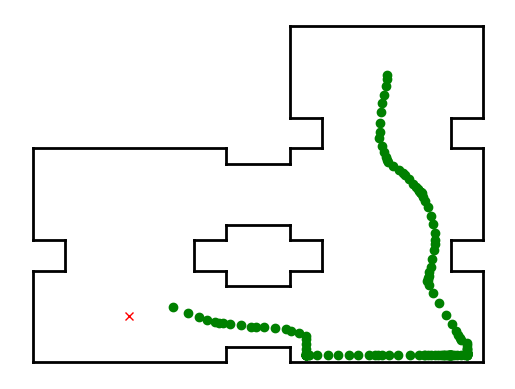

In [26]:
state = env.reset()
sum_reward = 0
n_step = 200
path = [] 
actions = [] 
action_string = ['left', 'right', 'forward']

for step in range(n_step):
    action = agent.compute_action(state)
    actions.append(action)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

print(f"actions:", [action_string[x] for x in actions])


import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/no_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, path)

In [ ]:
# average over 10 episodes
n = 20
total_reward = 0

for i in range(n):

      state = env.reset()
      sum_reward = 0
      n_step = 200
      path = [] 
      actions = [] 
      action_string = ['left', 'right', 'forward']

      for step in range(n_step):
          action = agent.compute_action(state)
          actions.append(action)
          state, reward, done, info = env.step(action)
          sum_reward += reward
          
          if len(info) > 0:
            path.append((info["X"], info["Y"]))

          #env.render()

          if done == 1:
              # report at the end of each episode
              print("cumulative reward", sum_reward)
              total_reward += sum_reward 
              print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

      if done == 0:
        total_reward += sum_reward 
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
      
#total_reward += sum_reward 
print(f"Average Reward: {total_reward/n}")
#print(f"actions:", [action_string[x] for x in actions])

# average reward over all checkpoints 

# No reward

In [42]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  total_steps = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              total_steps += step
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 
      total_steps += n_step

    #print(total_reward)

  chkpt_mean_rewards.append(total_steps/num_episodes)
          
print(chkpt_mean_rewards)


2022-09-21 20:34:05,038	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000001
2022-09-21 20:34:05,042	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 63.39686918258667, '_episodes_total': 25}


Total number of checkpoints:  16
checkpoint_000001
checkpoint_000020


2022-09-21 20:34:16,891	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000020
2022-09-21 20:34:16,894	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1235.0956757068634, '_episodes_total': 472}


checkpoint_000040


2022-09-21 20:34:29,946	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000040
2022-09-21 20:34:29,947	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2467.2414479255676, '_episodes_total': 940}


checkpoint_000060


2022-09-21 20:34:42,012	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000060
2022-09-21 20:34:42,014	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3694.297935962677, '_episodes_total': 1397}
2022-09-21 20:34:52,236	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000080
2022-09-21 20:34:52,239	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 5006.35972905159, '_episodes_total': 1862}


checkpoint_000080


2022-09-21 20:35:02,043	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000100
2022-09-21 20:35:02,045	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 6317.554915189743, '_episodes_total': 2320}


checkpoint_000100
checkpoint_000120


2022-09-21 20:35:14,840	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000120
2022-09-21 20:35:14,842	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 7628.516008377075, '_episodes_total': 2788}


checkpoint_000140


2022-09-21 20:35:27,048	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000140
2022-09-21 20:35:27,058	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 8939.258344173431, '_episodes_total': 3258}


checkpoint_000160


2022-09-21 20:35:41,071	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000160
2022-09-21 20:35:41,072	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 10250.2601583004, '_episodes_total': 3724}


checkpoint_000180


2022-09-21 20:35:53,023	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000180
2022-09-21 20:35:53,025	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 11563.234680891037, '_episodes_total': 4193}
2022-09-21 20:36:03,353	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000200
2022-09-21 20:36:03,355	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 12872.382250785828, '_episodes_total': 4646}


checkpoint_000200
checkpoint_000220


2022-09-21 20:36:22,270	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000220
2022-09-21 20:36:22,273	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 14181.829135417938, '_episodes_total': 5096}


checkpoint_000240


2022-09-21 20:36:34,303	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000240
2022-09-21 20:36:34,306	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 15493.405814886093, '_episodes_total': 5534}


checkpoint_000260


2022-09-21 20:36:45,899	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000260
2022-09-21 20:36:45,903	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 16801.593948602676, '_episodes_total': 5980}


checkpoint_000280


2022-09-21 20:36:56,923	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000280
2022-09-21 20:36:56,927	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 18109.32432103157, '_episodes_total': 6413}
2022-09-21 20:37:06,984	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000300
2022-09-21 20:37:06,989	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 19420.299421310425, '_episodes_total': 6851}


checkpoint_000300
[191.5, 199.0, 192.6, 197.0, 189.7, 199.0, 186.9, 199.0, 199.0, 199.0, 199.0, 199.0, 192.5, 180.3, 196.3, 199.0]


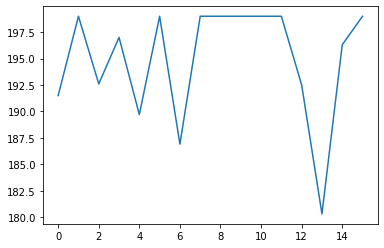

In [43]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Sparse setting

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)


          
chkpt_mean_rewards








2022-09-19 11:41:11,152	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000001
2022-09-19 11:41:11,155	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 41.4652841091156, '_episodes_total': 20}
2022-09-19 11:41:11,164	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Total number of checkpoints:  36
checkpoint_000001


2022-09-19 11:41:18,872	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000010
2022-09-19 11:41:18,876	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 411.0089066028595, '_episodes_total': 245}


checkpoint_000010


2022-09-19 11:41:26,548	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000020
2022-09-19 11:41:26,550	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 807.6356916427612, '_episodes_total': 486}


checkpoint_000020


2022-09-19 11:41:33,843	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000030
2022-09-19 11:41:33,846	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1207.9630284309387, '_episodes_total': 728}


checkpoint_000030


2022-09-19 11:41:41,534	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000040
2022-09-19 11:41:41,535	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 1610.0666103363037, '_episodes_total': 981}


checkpoint_000040


2022-09-19 11:41:49,299	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000050
2022-09-19 11:41:49,305	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2010.8285601139069, '_episodes_total': 1224}


checkpoint_000050


2022-09-19 11:41:56,966	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000060
2022-09-19 11:41:56,969	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 2411.301125764847, '_episodes_total': 1469}


checkpoint_000060


2022-09-19 11:42:04,721	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000070
2022-09-19 11:42:04,723	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 2807.460513830185, '_episodes_total': 1716}


checkpoint_000070


2022-09-19 11:42:12,416	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000080
2022-09-19 11:42:12,420	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3203.6906731128693, '_episodes_total': 1955}


checkpoint_000080


2022-09-19 11:42:20,143	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000090
2022-09-19 11:42:20,144	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 3600.449951648712, '_episodes_total': 2199}


checkpoint_000090


2022-09-19 11:42:27,911	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000100
2022-09-19 11:42:27,915	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 3996.6532003879547, '_episodes_total': 2442}


checkpoint_000100


2022-09-19 11:42:35,415	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000110
2022-09-19 11:42:35,417	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 4392.204572200775, '_episodes_total': 2697}


checkpoint_000110


2022-09-19 11:42:43,158	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000120
2022-09-19 11:42:43,163	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 4788.656108617783, '_episodes_total': 2934}


checkpoint_000120


2022-09-19 11:42:50,519	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000130
2022-09-19 11:42:50,520	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 5184.884035348892, '_episodes_total': 3171}


checkpoint_000130


2022-09-19 11:42:56,963	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000140
2022-09-19 11:42:56,964	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 5581.018518447876, '_episodes_total': 3400}


checkpoint_000140


2022-09-19 11:43:04,020	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000150
2022-09-19 11:43:04,022	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 6027.886910676956, '_episodes_total': 3629}


checkpoint_000150


2022-09-19 11:43:11,665	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000160
2022-09-19 11:43:11,667	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 6475.763517856598, '_episodes_total': 3855}


checkpoint_000160


2022-09-19 11:43:18,696	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000170
2022-09-19 11:43:18,701	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 6923.168088674545, '_episodes_total': 4080}


checkpoint_000170


2022-09-19 11:43:24,626	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000180
2022-09-19 11:43:24,629	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 7371.331375837326, '_episodes_total': 4303}


checkpoint_000180


2022-09-19 11:43:32,228	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000190
2022-09-19 11:43:32,235	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 7819.971398830414, '_episodes_total': 4520}


checkpoint_000190


2022-09-19 11:43:38,087	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000200
2022-09-19 11:43:38,088	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 8269.639487981796, '_episodes_total': 4735}


checkpoint_000200


2022-09-19 11:43:45,964	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000210
2022-09-19 11:43:45,965	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 8712.886793136597, '_episodes_total': 4957}


checkpoint_000210


2022-09-19 11:43:52,609	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000220
2022-09-19 11:43:52,611	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 9156.902575492859, '_episodes_total': 5180}


checkpoint_000220


2022-09-19 11:43:59,711	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000230
2022-09-19 11:43:59,713	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 9601.465784549713, '_episodes_total': 5398}


checkpoint_000230


2022-09-19 11:44:05,611	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000240
2022-09-19 11:44:05,614	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 10046.50104188919, '_episodes_total': 5617}


checkpoint_000240


2022-09-19 11:44:13,350	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000250
2022-09-19 11:44:13,356	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 10491.385877132416, '_episodes_total': 5838}


checkpoint_000250


2022-09-19 11:44:20,409	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000260
2022-09-19 11:44:20,411	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 10937.096534252167, '_episodes_total': 6071}


checkpoint_000260


2022-09-19 11:44:27,217	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000270
2022-09-19 11:44:27,219	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 11382.581054210663, '_episodes_total': 6282}


checkpoint_000270


2022-09-19 11:44:34,248	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000280
2022-09-19 11:44:34,250	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 11827.007471323013, '_episodes_total': 6507}


checkpoint_000280


2022-09-19 11:44:41,876	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000290
2022-09-19 11:44:41,882	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 12272.015307426453, '_episodes_total': 6723}


checkpoint_000290


2022-09-19 11:44:48,887	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000300
2022-09-19 11:44:48,889	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 12716.460474967957, '_episodes_total': 6946}


checkpoint_000300


2022-09-19 11:44:56,582	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000310
2022-09-19 11:44:56,584	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 13160.884176969528, '_episodes_total': 7164}


checkpoint_000310


2022-09-19 11:45:04,259	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000320
2022-09-19 11:45:04,260	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 13606.345027685165, '_episodes_total': 7382}


checkpoint_000320


2022-09-19 11:45:11,329	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000330
2022-09-19 11:45:11,330	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 14053.651854515076, '_episodes_total': 7612}


checkpoint_000330


2022-09-19 11:45:18,962	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000340
2022-09-19 11:45:18,964	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 14500.158278226852, '_episodes_total': 7833}


checkpoint_000340


2022-09-19 11:45:26,723	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/sparse/checkpoint_000350
2022-09-19 11:45:26,726	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 14947.269214868546, '_episodes_total': 8060}


checkpoint_000350


[1.0,
 1.1,
 2.2,
 1.5,
 1.2,
 1.3,
 1.0,
 1.0,
 1.0,
 1.3,
 2.2,
 1.1,
 4.1,
 3.0,
 2.1,
 1.3,
 3.0,
 4.0,
 2.1,
 4.4,
 1.1,
 3.3,
 2.1,
 6.1,
 1.1,
 2.5,
 3.2,
 2.4,
 1.5,
 2.5,
 1.5,
 2.8,
 3.7,
 1.9,
 1.8,
 3.0]

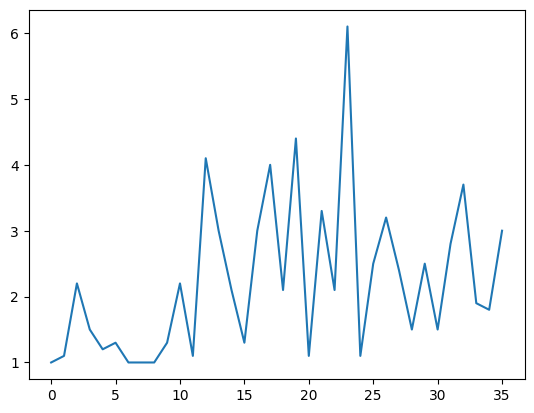

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

In [ ]:
checkpoints[(36-13):]

['checkpoint_000230',
 'checkpoint_000240',
 'checkpoint_000250',
 'checkpoint_000260',
 'checkpoint_000270',
 'checkpoint_000280',
 'checkpoint_000290',
 'checkpoint_000300',
 'checkpoint_000310',
 'checkpoint_000320',
 'checkpoint_000330',
 'checkpoint_000340',
 'checkpoint_000350']

# Dense Setting

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)


          
print(chkpt_mean_rewards)








Total number of checkpoints:  25
checkpoint_000001


2022-09-19 11:25:11,658	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000001
2022-09-19 11:25:11,662	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 42.16753888130188, '_episodes_total': 24}
2022-09-19 11:25:11,670	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!
2022-09-19 11:25:20,091	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000005
2022-09-19 11:25:20,094	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': None, '_time_total': 211.92539024353027, '_episodes_total': 120}


checkpoint_000005


2022-09-19 11:25:27,675	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000015
2022-09-19 11:25:27,676	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': None, '_time_total': 637.0210475921631, '_episodes_total': 352}


checkpoint_000015


2022-09-19 11:25:35,213	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000025
2022-09-19 11:25:35,218	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': None, '_time_total': 1061.4130041599274, '_episodes_total': 578}


checkpoint_000025


2022-09-19 11:25:42,726	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000035
2022-09-19 11:25:42,729	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 35, '_timesteps_total': None, '_time_total': 1485.1415386199951, '_episodes_total': 803}


checkpoint_000035


2022-09-19 11:25:50,049	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000045
2022-09-19 11:25:50,053	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 45, '_timesteps_total': None, '_time_total': 1908.9701690673828, '_episodes_total': 1041}


checkpoint_000045


2022-09-19 11:25:57,604	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000055
2022-09-19 11:25:57,606	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 55, '_timesteps_total': None, '_time_total': 2333.3257925510406, '_episodes_total': 1282}


checkpoint_000055


2022-09-19 11:26:05,226	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000065
2022-09-19 11:26:05,231	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 65, '_timesteps_total': None, '_time_total': 2756.1853380203247, '_episodes_total': 1514}


checkpoint_000065


2022-09-19 11:26:12,870	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000070
2022-09-19 11:26:12,876	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 2968.3246862888336, '_episodes_total': 1637}


checkpoint_000070


2022-09-19 11:26:20,550	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000075
2022-09-19 11:26:20,552	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 75, '_timesteps_total': None, '_time_total': 3179.0191192626953, '_episodes_total': 1759}


checkpoint_000075


2022-09-19 11:26:28,182	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000080
2022-09-19 11:26:28,186	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3389.882183074951, '_episodes_total': 1877}


checkpoint_000080


2022-09-19 11:26:35,778	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000085
2022-09-19 11:26:35,781	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 85, '_timesteps_total': None, '_time_total': 3601.2166805267334, '_episodes_total': 1995}


checkpoint_000085


2022-09-19 11:26:42,778	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000090
2022-09-19 11:26:42,780	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 3812.1939086914062, '_episodes_total': 2111}


checkpoint_000090


2022-09-19 11:26:50,190	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000095
2022-09-19 11:26:50,198	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 95, '_timesteps_total': None, '_time_total': 4023.517053127289, '_episodes_total': 2226}


checkpoint_000095


2022-09-19 11:26:57,052	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000100
2022-09-19 11:26:57,057	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 4235.071677207947, '_episodes_total': 2342}


checkpoint_000100


2022-09-19 11:27:04,061	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000110
2022-09-19 11:27:04,064	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 4692.738503217697, '_episodes_total': 2575}


checkpoint_000110


2022-09-19 11:27:11,609	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000120
2022-09-19 11:27:11,610	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 5152.419021606445, '_episodes_total': 2815}


checkpoint_000120


2022-09-19 11:27:18,585	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000130
2022-09-19 11:27:18,587	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 5613.72233915329, '_episodes_total': 3047}


checkpoint_000130


2022-09-19 11:27:26,195	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000140
2022-09-19 11:27:26,196	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 6076.45273399353, '_episodes_total': 3300}


checkpoint_000140


2022-09-19 11:27:33,229	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000150
2022-09-19 11:27:33,231	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 6539.11448764801, '_episodes_total': 3543}


checkpoint_000150


2022-09-19 11:27:40,303	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000160
2022-09-19 11:27:40,305	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 7000.275754928589, '_episodes_total': 3793}


checkpoint_000160


2022-09-19 11:27:46,971	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000170
2022-09-19 11:27:46,977	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 7462.469846725464, '_episodes_total': 4038}


checkpoint_000170


2022-09-19 11:27:53,820	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000180
2022-09-19 11:27:53,821	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 7924.028053998947, '_episodes_total': 4286}


checkpoint_000180


2022-09-19 11:28:00,191	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000190
2022-09-19 11:28:00,196	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 8385.379112005234, '_episodes_total': 4532}


checkpoint_000190


2022-09-19 11:28:07,566	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000200
2022-09-19 11:28:07,568	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 8848.39952993393, '_episodes_total': 4775}


checkpoint_000200
[2.9, 2.1, 2.9, 2.5, 3.6, 2.5, 3.3, 2.8, 2.9, 3.0, 2.4, 3.6, 4.4, 6.4, 5.5, 4.4, 5.8, 3.6, 4.8, 5.7, 6.8, 8.1, 7.7, 5.4, 8.5]


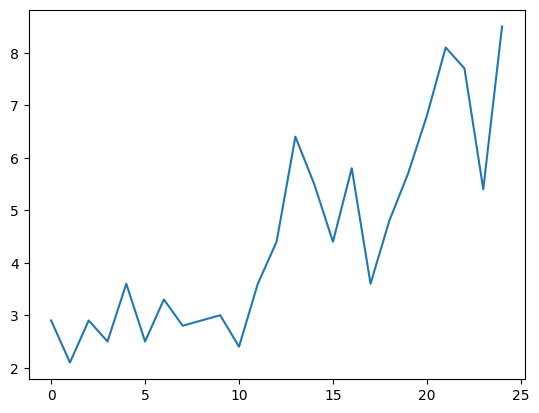

In [ ]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Easy 1 room setting 

In [ ]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense"#_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]

print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 

for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10 
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)
          
print(chkpt_mean_rewards)

Total number of checkpoints:  42
checkpoint_000001


2022-09-19 11:14:37,856	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000001
2022-09-19 11:14:37,857	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 41.721397161483765, '_episodes_total': 45}
2022-09-19 11:14:45,565	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000005
2022-09-19 11:14:45,571	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': None, '_time_total': 207.62326288223267, '_episodes_total': 256}


checkpoint_000005


2022-09-19 11:14:51,727	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000010
2022-09-19 11:14:51,732	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 415.8501167297363, '_episodes_total': 521}


checkpoint_000010


2022-09-19 11:14:58,562	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000015
2022-09-19 11:14:58,563	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': None, '_time_total': 624.1769771575928, '_episodes_total': 784}


checkpoint_000015


2022-09-19 11:15:05,334	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000020
2022-09-19 11:15:05,337	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 833.6727373600006, '_episodes_total': 1040}


checkpoint_000020


2022-09-19 11:15:12,429	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000025
2022-09-19 11:15:12,433	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': None, '_time_total': 1043.6415495872498, '_episodes_total': 1302}


checkpoint_000025


2022-09-19 11:15:18,708	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000030
2022-09-19 11:15:18,711	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1252.2961168289185, '_episodes_total': 1567}


checkpoint_000030


2022-09-19 11:15:25,712	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000035
2022-09-19 11:15:25,715	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 35, '_timesteps_total': None, '_time_total': 1460.7080266475677, '_episodes_total': 1817}


checkpoint_000035


2022-09-19 11:15:32,793	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000040
2022-09-19 11:15:32,795	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 1669.9806778430939, '_episodes_total': 2072}


checkpoint_000040


2022-09-19 11:15:39,387	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000045
2022-09-19 11:15:39,389	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 45, '_timesteps_total': None, '_time_total': 1878.9090399742126, '_episodes_total': 2306}


checkpoint_000045


2022-09-19 11:15:46,112	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000050
2022-09-19 11:15:46,118	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2087.8931288719177, '_episodes_total': 2565}


checkpoint_000050


2022-09-19 11:15:53,149	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000055
2022-09-19 11:15:53,151	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 55, '_timesteps_total': None, '_time_total': 2297.659675359726, '_episodes_total': 2816}


checkpoint_000055


2022-09-19 11:15:59,342	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000060
2022-09-19 11:15:59,345	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 2509.7385313510895, '_episodes_total': 3048}


checkpoint_000060


2022-09-19 11:16:06,529	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000065
2022-09-19 11:16:06,531	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 65, '_timesteps_total': None, '_time_total': 2721.181494474411, '_episodes_total': 3303}


checkpoint_000065


2022-09-19 11:16:12,559	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000070
2022-09-19 11:16:12,560	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 2933.144382238388, '_episodes_total': 3543}


checkpoint_000070


2022-09-19 11:16:19,788	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000075
2022-09-19 11:16:19,790	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 75, '_timesteps_total': None, '_time_total': 3145.0839812755585, '_episodes_total': 3772}


checkpoint_000075


2022-09-19 11:16:27,152	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000080
2022-09-19 11:16:27,154	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3357.21462225914, '_episodes_total': 4010}


checkpoint_000080


2022-09-19 11:16:34,258	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000085
2022-09-19 11:16:34,260	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 85, '_timesteps_total': None, '_time_total': 3569.597920894623, '_episodes_total': 4247}


checkpoint_000085


2022-09-19 11:16:41,231	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000090
2022-09-19 11:16:41,233	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 3781.704222202301, '_episodes_total': 4484}


checkpoint_000090


2022-09-19 11:16:47,628	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000095
2022-09-19 11:16:47,629	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 95, '_timesteps_total': None, '_time_total': 3991.746313095093, '_episodes_total': 4703}


checkpoint_000095


2022-09-19 11:16:54,926	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000100
2022-09-19 11:16:54,928	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 4201.262814998627, '_episodes_total': 4922}


checkpoint_000100


2022-09-19 11:17:02,377	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000101
2022-09-19 11:17:02,383	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 101, '_timesteps_total': None, '_time_total': 4243.20450758934, '_episodes_total': 4967}


checkpoint_000101


2022-09-19 11:17:09,525	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000105
2022-09-19 11:17:09,528	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 105, '_timesteps_total': None, '_time_total': 4410.332643985748, '_episodes_total': 5147}


checkpoint_000105


2022-09-19 11:17:17,000	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000110
2022-09-19 11:17:17,002	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 4618.7047238349915, '_episodes_total': 5374}


checkpoint_000110


2022-09-19 11:17:24,479	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000115
2022-09-19 11:17:24,481	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 115, '_timesteps_total': None, '_time_total': 4828.154140472412, '_episodes_total': 5597}


checkpoint_000115


2022-09-19 11:17:31,885	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000120
2022-09-19 11:17:31,889	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 5037.143219470978, '_episodes_total': 5817}


checkpoint_000120


2022-09-19 11:17:39,369	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000125
2022-09-19 11:17:39,371	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 125, '_timesteps_total': None, '_time_total': 5246.834551334381, '_episodes_total': 6046}


checkpoint_000125


2022-09-19 11:17:46,929	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000130
2022-09-19 11:17:46,931	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 5457.93306517601, '_episodes_total': 6265}


checkpoint_000130


2022-09-19 11:17:54,607	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000135
2022-09-19 11:17:54,609	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 135, '_timesteps_total': None, '_time_total': 5668.879067897797, '_episodes_total': 6488}


checkpoint_000135


2022-09-19 11:18:01,844	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000140
2022-09-19 11:18:01,847	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 5879.946669816971, '_episodes_total': 6707}


checkpoint_000140


2022-09-19 11:18:09,019	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000145
2022-09-19 11:18:09,021	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 145, '_timesteps_total': None, '_time_total': 6091.460388422012, '_episodes_total': 6924}


checkpoint_000145


2022-09-19 11:18:16,469	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000150
2022-09-19 11:18:16,474	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 6301.722088336945, '_episodes_total': 7142}


checkpoint_000150


2022-09-19 11:18:23,693	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000155
2022-09-19 11:18:23,695	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 155, '_timesteps_total': None, '_time_total': 6512.946937799454, '_episodes_total': 7357}


checkpoint_000155


2022-09-19 11:18:32,291	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000160
2022-09-19 11:18:32,293	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 6723.457304954529, '_episodes_total': 7578}


checkpoint_000160


2022-09-19 11:18:41,148	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000165
2022-09-19 11:18:41,149	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 165, '_timesteps_total': None, '_time_total': 6933.614919900894, '_episodes_total': 7800}


checkpoint_000165


2022-09-19 11:18:49,230	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000170
2022-09-19 11:18:49,235	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 7144.000383138657, '_episodes_total': 8021}


checkpoint_000170


2022-09-19 11:18:56,704	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000175
2022-09-19 11:18:56,706	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 175, '_timesteps_total': None, '_time_total': 7354.346156835556, '_episodes_total': 8237}


checkpoint_000175


2022-09-19 11:19:04,222	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000180
2022-09-19 11:19:04,223	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 7564.682641983032, '_episodes_total': 8460}


checkpoint_000180


2022-09-19 11:19:11,681	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000185
2022-09-19 11:19:11,686	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 185, '_timesteps_total': None, '_time_total': 7774.837239027023, '_episodes_total': 8672}


checkpoint_000185


2022-09-19 11:19:19,174	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000190
2022-09-19 11:19:19,176	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 7985.33084654808, '_episodes_total': 8890}


checkpoint_000190


2022-09-19 11:19:26,664	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000195
2022-09-19 11:19:26,666	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 195, '_timesteps_total': None, '_time_total': 8193.688444375992, '_episodes_total': 9108}


checkpoint_000195


2022-09-19 11:19:34,134	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense/checkpoint_000200
2022-09-19 11:19:34,136	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 8403.854105472565, '_episodes_total': 9325}


checkpoint_000200


[2.3,
 5.6,
 4.7,
 3.5,
 2.6,
 4.8,
 4.7,
 2.8,
 5.9,
 6.9,
 2.7,
 5.3,
 3.6,
 5.0,
 2.5,
 4.5,
 6.5,
 2.5,
 5.4,
 1.9,
 1.6,
 1.9,
 1.0,
 0.8,
 1.7,
 0.3,
 0.7,
 0.5,
 2.1,
 2.5,
 1.1,
 1.6,
 1.0,
 2.0,
 1.0,
 0.8,
 0.5,
 0.9,
 0.4,
 0.6,
 1.5,
 0.7]

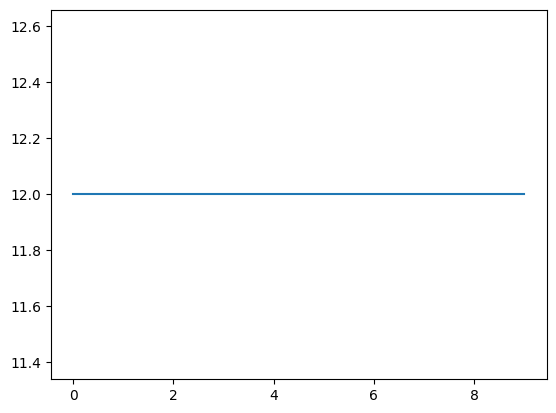

In [ ]:
#on model with no time penalty 
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

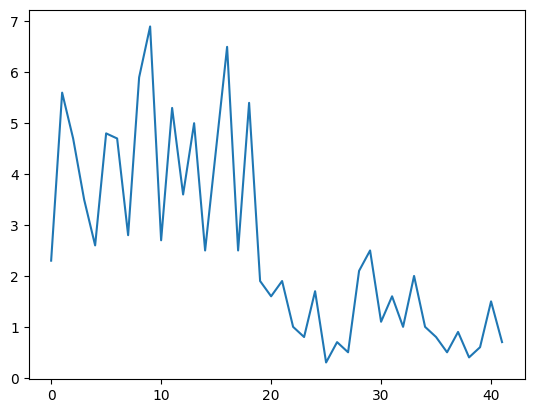

In [ ]:
#on model with no time penalty 
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Visualize Path taken by agent

Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/new_sparse_rs.wad
Health Bonus locations: [(-544.0, 96.0), (-544.0, 352.0), (-800.0, 96.0)]
Armor location: [(-544.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -64.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640.0, -448.0, 448.0, 448.0), (-608.0, -64

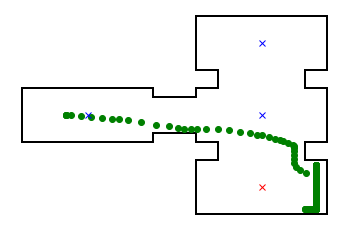

In [ ]:
import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/new_sparse_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, path)




/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


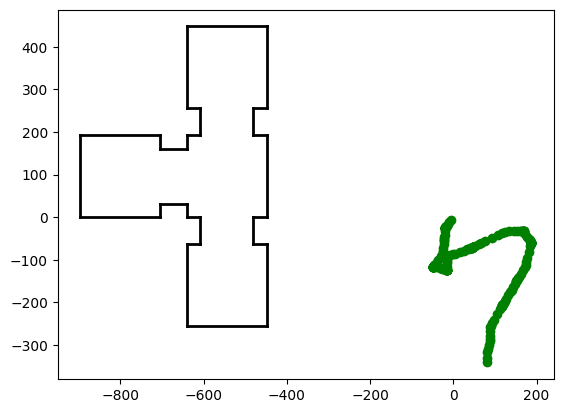

In [ ]:
import matplotlib.pyplot as plt

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

for pos in path[7:]:
        plt.plot(pos[0], pos[1], color='green', marker='o')

plt.show()

    